In [4]:
import numpy as np
import librosa
from matplotlib import pyplot as plt

def pitchYIN(audioFile, threshold = 0.2, wsize = 0.08, hop = 0.02, minFreq= 65):
    """Returns a vector of pitch values from the (assumed monophonic) audio
    file, using the following input parameters:
    audioFile: file name of audio to process
    threshold: voicing threshold used by YIN (default=0.2)
    wsize: size of window used by YIN (default=80ms)
    hop: hop size between successive frames (default=20ms)
    minFreq: minimum fundamental frequency to detect (default=65Hz, approx C2)
    """

    plotting = 0                            # for development
    sig, fs = librosa.load(audioFile)       # Load audio
    wsize = int(round(wsize * fs))          # Convert to samples
    hop = int(round(hop * fs))              # Convert to samples
    maxlag = int(np.ceil(fs / minFreq))     # Convert to samples
    pin  = 0                                # Current frame sample index
    pend = len(sig)                         # Stop sample index

    # Centre the frames and normalise signal
    sig = (np.concatenate((np.zeros(wsize//2), sig, np.zeros(wsize//2+maxlag)))
                / max(abs(sig)))

    # Initialise variables and plot
    frameNum = 0
    pitch = np.zeros(int(np.ceil(pend / hop)))
    d = np.zeros(maxlag-1)
    yin = np.ones(maxlag)
    if plotting:
        plt.figure(figsize = (8,4))

    # Loop through all frames in the file
    while pin < pend:
        # Loop for each pitch; ACF with FFT would be much faster
        for j in range(1,maxlag):
            d[j-1] = sum(np.square(sig[pin:pin+wsize] - sig[pin+j:pin+wsize+j]))
        # Normalise the difference function, avoiding divide by zero errors
        cmean = np.cumsum(d) / np.arange(1,maxlag)  # Cumulative mean for norm.
        yin[1:] = np.divide(d, cmean, out = np.zeros_like(d), where = cmean!=0)
        # Get first minimum below threshold
        idx1 = np.nonzero(yin < threshold)[0]
        pitch[frameNum] = 0
        idx = 0
        if len(idx1):                               # Ignore if no suitable min
            stopAt = np.nonzero(np.diff(idx1) > 1)[0]# Find end of values < thr
            if len(stopAt):
                idx2 = np.argmin(yin[idx1[0:stopAt[0]+1]])
            else:
                idx2 = np.argmin(yin[idx1[0:]])
            idx = idx1[idx2]                        # Lag (period) of minimum
            # Refine with quadratic interpolation
            # see http://ccrma.stanford.edu/~jos/sasp/Quadratic_Peak_Interpolation.html
            num = yin[idx-1] - yin[idx+1]
            den = yin[idx-1] - 2 * yin[idx] + yin[idx+1]
            if (den != 0):
                pitch[frameNum] = fs / (idx + num / den / 2)
        # Show progress every 100 frames
        if frameNum % 100 == 0:
            if plotting:
                plt.clf()
                plt.plot(yin)
                plt.axvline(idx)
                plt.show()
            if idx > 0:
                print('frame={:5d} f0={:5.1f} d={:3.3f}'.format(
                    frameNum, pitch[frameNum], yin[idx]))
            else:
                print('frame={:5d}   Unpitched'.format(frameNum))
            if plotting:
                input('Press enter to continue:')
        # Increment variables for next iteration
        pin += hop
        frameNum += 1
    return pitch


frame=    0   Unpitched
frame=  100   Unpitched
frame=  200   Unpitched
frame=  300   Unpitched
frame=  400 f0=154.1 d=0.109
frame=  500 f0=175.7 d=0.142
frame=  600   Unpitched
frame=  700   Unpitched
frame=  800 f0=228.0 d=0.147
frame=  900   Unpitched
frame= 1000   Unpitched
frame= 1100   Unpitched
frame= 1200 f0=180.8 d=0.112
frame= 1300 f0=136.9 d=0.122
frame= 1400 f0=207.8 d=0.088
frame= 1500   Unpitched
frame= 1600   Unpitched
frame= 1700 f0=235.4 d=0.115
frame= 1800 f0=186.7 d=0.191
frame= 1900 f0=156.5 d=0.232
frame= 2000 f0=177.8 d=0.244
frame= 2100   Unpitched
frame= 2200   Unpitched
frame= 2300 f0=229.3 d=0.225
frame= 2400   Unpitched
frame= 2500 f0=187.9 d=0.115
frame= 2600   Unpitched


<IPython.core.display.Javascript object>


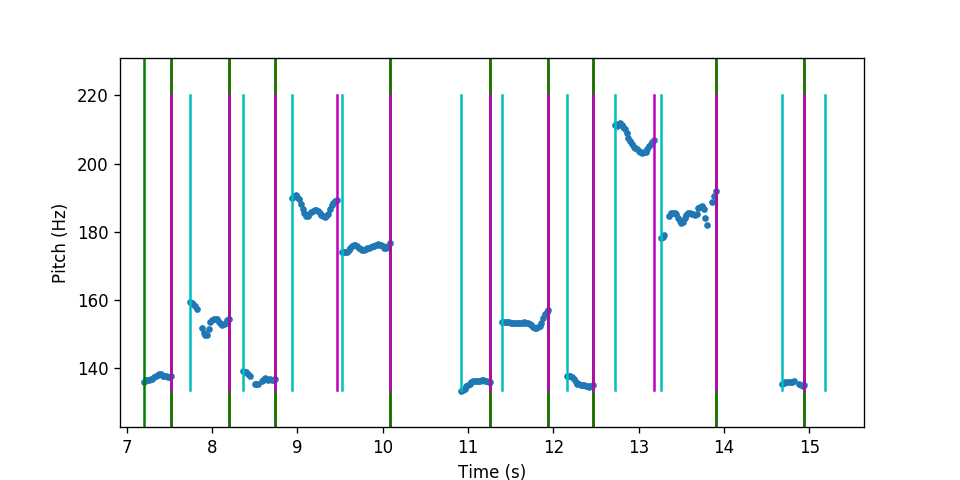

In [5]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np

threshold = 0.25
wsize = 0.1
hop = 0.02
if not (('f0' in locals()) or ('f0' in globals())):
    f0 = pitchYIN('data/happyBirthday.wav', threshold, wsize, hop)
idx = np.nonzero(f0 > 0)[0]
plt.figure(figsize = (8, 4))
plt.plot(np.multiply(idx, hop), f0[idx], '.')
plt.xlabel('Time (s)')
plt.ylabel('Pitch (Hz)')
# Find boundaries where there is >100ms gap in voicing
boundaries = np.nonzero(np.diff(idx) > 0.1 / hop)[0]
endIndex = np.append(boundaries, [-1])
vEnd = idx[(endIndex)] * hop             # ends of notes
startIndex = np.append([0], boundaries)
vStart = idx[(startIndex)] * hop         # beginnings of notes
for i in range(len(vEnd)):
    plt.axvline(vEnd[i], color = 'r')
    plt.axvline(vStart[i], color = 'g')
# Find boundaries where there is >1 semitone pitch difference
boundaries = np.nonzero(abs(np.diff(np.log2(f0[idx]))) > 1/12)[0]
pEnd = idx[boundaries] * hop
pStart = idx[boundaries+1] * hop
for i in range(len(pEnd)):
    plt.axvline(pEnd[i], ymin = 0.1, ymax = 0.9, color = 'm')
    plt.axvline(pStart[i], ymin = 0.1, ymax = 0.9, color = 'c')

<IPython.core.display.Javascript object>


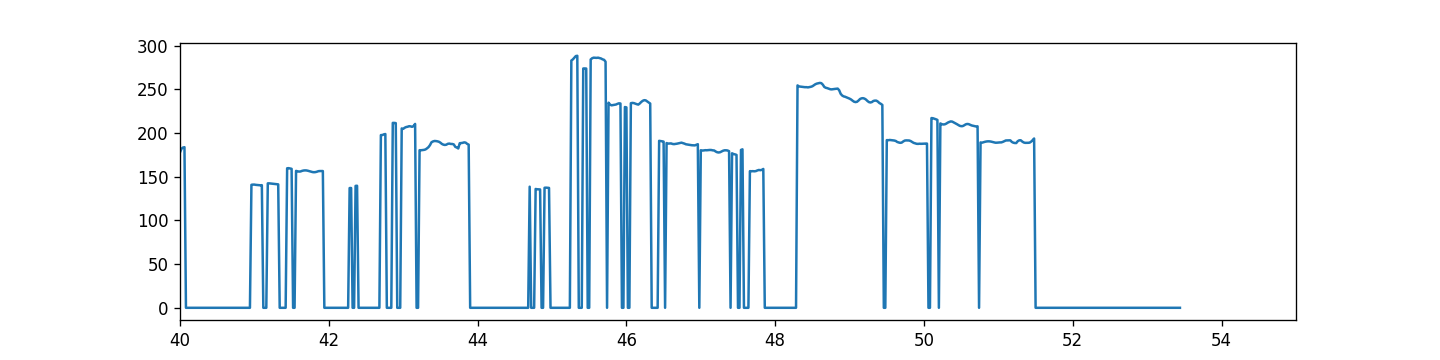

(40, 55)

In [6]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(12,3))
plt.plot(np.arange(len(f0))*0.02, f0)
plt.xlim([40,55])